UFRJ/EQ, Agosto de 2018.

# Cálculo de equilíbrio líquido-vapor de substância pura com equação de estado cúbica.

# Introdução

O objetivo dessa aula é apresentar uma metodologia de resolução computacional de equação de estado cúbica.

> Por resolução, entendamos (1) cálculo de pressão a partir de volume e temperatura, (2) cálculo de volume a partir de pressão e temperatura e (3) cálculo de propriedades residuais (entalpia, entropia, energia de Helmholtz, energia de Gibbs).

Além disso, é apresentada uma metodologia para o cálculo de equilíbrio líquido vapor a partir do critério de igualdade de potencial químico do componente em cada fase.

> O critério de equlíbrio é satisfeito utilizando os cálculos de energia de Gibbs residual a partir da equação de estado.

Esta aula se limita ao estudo de substâncias puras.

> São estudadas a relação $P,V,T$ de substância pura em estado líquido ou vapor e em equilíbrio de fases, e a curva univariante de pressão de saturação.

Os cálculos que seguem são realizados utilizado a equação de estado cúbica de Soave para a substância Metano.

> São utilizados o equacionamento e parâmetros apresentados por Reid, Prausnitz & Poling, 1987 e por Smith, van Ness & Abbott, 2007.

>* Vamos trabalhar apenas com propriedades intensivas, portanto convém usar a notação simplificada: $P$ para pressão, $T$ para temperatura, $V$, $H$, $S$, $A$ e $G$ para volume molar, entalpia molar, entropia molar, energia de Helmholtz molar e energia de Gibbs molar.

# Metodologia

Essa aula é dividida nas seguintes etapas:

1. programação $P(T,V)$ usando a equação de Soave (Reid, Prausnitz & Poling, 1987 - pp 42, 43)
  1. cálculo em sequência de $P$ versus sequência de $V$ para dados $T$
  1. desenhar isotermas no plano $P$ versus $V$
1. programação $V(P,T)$ usando método de solução de raiz de polinômios (numpy.roots)
  1. implementar lógica de classificação de raízes de volume (líquido, vapor, intermediária e não física)
  1. comparar calculos pontuais com as isotermas
1. programação de pressão limite superior e inferior para cálculo de equilibrio de fases (baseado em Topliss, Dimitrelis & Prausnitz, 1988)
  1. comparar calculos pontuais com as isotermas
1. programação de energia de gibbs residual (Reid, Prausnitz & Poling, 1987)
  1. cálculo em sequência $G^{\mathrm{RES},L}$ e sequência $G^{\mathrm{RES},V}$ versus sequência $P$ para dado $T$
  1. desenhar $G^{\mathrm{RES},L}$ e $G^{\mathrm{RES},V}$ versus $P$ para dado $T$ e verificar existência de solução para o critério de equilíbrio de fases.
1. programação de resolução da pressão de saturação usando método de bisseção (scipy.optimize.bisect)
    1. cálculo em sequência de pressão de saturação versus sequência de $T$
    1. desenhar $P^\mathrm{SAT}$ versus $T$
1. geração do envelope de fases no plano $P$ versus $V$ (Smith, van Ness & Abbott, 2007)
    1. cálculo em sequência de volumes de líquido e olume de vapor para cada par $(T,P)$ na curva de $P^\mathrm{SAT}$
    1. desenhar envelope de fases no diagrama $P$ versus $V$ com algumas isotermas
1. programação de entalpia e entropia residuais (Reid, Prausnitz & Poling, 1987) - TAREFA
    1. testar pontualmente
1. geração dos envelope de fases nos planos $T$ versus $S^\mathrm{RES}$ e $P$ versus $H^\mathrm{RES}$ (Smith, van Ness & Abbott, 2007)
    1. cálculo em sequência de entalpia e entropia residuais de líquido e de vapor para cada par $(T,P)$ na curva de $P^\mathrm{SAT}$
    1. desenhar envelope de fases no diagrama T versus $S^\mathrm{RES}$ com algumas isóbaras
    1. desenhar envelope de fases no diagrama P versus $H^\mathrm{RES}$ com algumas isotermas

## carregando pacotes utilizados nesta aula:

In [1]:
import numpy as np
#1. arrays (vetores R^n) para cálculos em sequência
#2. resolução de raiz de polinômios (np.roots)

from matplotlib import pyplot as plt
# pacote para desenhar gráficos
%matplotlib inline
# comando para integrar or gráficos no arquivo notebook

from scipy import optimize as opt
# resolução de equação não linear por método de biseção (opt.bisect)

# Implementação, resultados e discussão

## A equação de Soave
é uma equação de estado dada pela expressão de pressão em função de temperatura e volume molar abaixo

$$P=\frac{RT}{V-b}-\frac{a}{V^2+ubV+wb^2}$$

em que

> $u=1$
>
> $w=0$
>
> $b=\frac{0.08664RT_c}{P_c}$
>
> $a=\frac{0.42748R^2T_c^2}{P_c}(1+f(1-(T/T_c)^{(1/2)}))^2$
>
>$f=0.48+1.574\omega-0.176\omega^2$

> Reid, Prausnitz & Poling, 1987 pp 42, 43

Nota-se que sua parametrização ($a$,$b$) é dada em função de propriedades do componente (temperatura crítica - $T_c$, pressão crítica - $P_c$, e o fator acêntrico de Pitzer - $\omega$ )

Os parâmetros $u$ e $w$ servem para representar a equação de Soave na forma geral em que também se encaixam as equações de van der Waals; Redlich e Kwong; e Peng e Robinson utilizada por Reid, Prausnitz e Poling, 1987.

> Abaixo são dadas as propriedades para o metano
> (Smith, van Ness & Abbott, 2007, pp 632, 633)

In [2]:
Tc= 190.6 #K
Pc= 45.99e5 #bar
omega= 0.012 #adimensional

Aqui é definida como constante global do roteiro de cálculo da aula a constante de gases $R$ em unidades do sistema internacional S.I.

In [3]:
R=8.314

Aqui é implementada a equação de estado apresentada
> A implementação é feita como uma função de temperatura e volume molar retornando pressão,
>
> Essa equação conta com constantes ou parâmetros globais $R$, $a$ e $b$
>
> Notemos que o parâmetro $a$ da equação de Soave depende da temperatura, dessa forma faremos a implementação desse parâmetro como uma função global `func_a(T)`

In [4]:
def func_P_soave(T,Vm):
    a=func_a(T=T)
    return R*T/(Vm-b) - a/(Vm**2 + u*b*Vm + w*b**2)

# Soave
u=1
w=0

b=(0.08664*R*Tc)/Pc
ac=0.42748*R**2*Tc**2/Pc

def func_a(T):
    Tr=T/Tc
    return ac*(1+f_omega*(1-Tr**(.5)))**2

f_omega = 0.48 + 1.574*omega-0.176*omega**2

## Cálculo

* testes

Podemos arbitrar valores de temperatura e volume molar para verificar se a função retorna valores coerentes

In [5]:
Ptest=func_P_soave(T=170,Vm=b*1.01)
print( Ptest)

4598201536.582451


* vetorizado

Aqui definimos array (vetor $\mathbb{R}^n$) contendo uma sequência finita de valores arbitrados para volume molar

> vamos usar um array de tamanho 100 para termos uma quantidade tal de valores calculados que possamos apreciá-la em um gráfico

Realizaremos o cálculo de pressão para cada elemento do array de volume molar, resultando em um array de valores calculados para pressão em data temperatura.

In [6]:
Ttest=170.
nV=100
minV=b*1.01
maxV=1e-1
seqVm= np.logspace(np.log10(minV),np.log10(maxV),nV)
print( "Vm:", seqVm )

seqP=np.zeros(nV)
for i in range(nV):
    seqP[i]=func_P_soave(T=Ttest,Vm=seqVm[i])

print( "P:", seqP )

Vm: [  3.01515279e-05   3.27244123e-05   3.55168457e-05   3.85475624e-05
   4.18368957e-05   4.54069138e-05   4.92815679e-05   5.34868533e-05
   5.80509834e-05   6.30045789e-05   6.83808736e-05   7.42159374e-05
   8.05489177e-05   8.74223026e-05   9.48822060e-05   1.02978676e-04
   1.11766033e-04   1.21303231e-04   1.31654256e-04   1.42888552e-04
   1.55081490e-04   1.68314875e-04   1.82677488e-04   1.98265688e-04
   2.15184058e-04   2.33546104e-04   2.53475016e-04   2.75104497e-04
   2.98579662e-04   3.24058005e-04   3.51710462e-04   3.81722552e-04
   4.14295628e-04   4.49648224e-04   4.88017522e-04   5.29660940e-04
   5.74857867e-04   6.23911529e-04   6.77151030e-04   7.34933553e-04
   7.97646764e-04   8.65711406e-04   9.39584127e-04   1.01976054e-03
   1.10677856e-03   1.20122197e-03   1.30372442e-03   1.41497358e-03
   1.53571584e-03   1.66676125e-03   1.80898901e-03   1.96335332e-03
   2.13088981e-03   2.31272249e-03   2.51007129e-03   2.72426022e-03
   2.95672627e-03   3.20902908

* plot

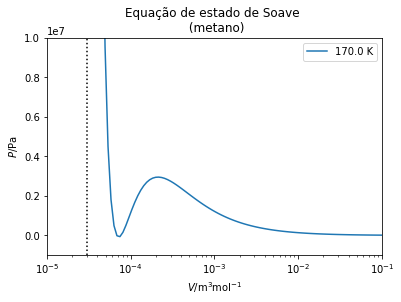

In [7]:
plt.plot(seqVm,seqP,label=str(Ttest)+' K') #create a logarithm vs logarithm scale plot of pressure vs volume, using the function pressure in each value of the volume list
plt.axvline(b,color='black',ls=":")
plt.ylabel(r'$P / \mathrm{Pa}$') #create labels to be displayed in y axis of the plot
plt.xlabel(r'${V} / \mathrm{m^{3}mol^{-1}}$') #use matplotlib's  mathtext to create special symbols in the x label
plt.title('Equação de estado de Soave \n (metano)') #create a title for the figure
plt.ylim(-1e6,1e7)#define max and min limits of the y axis only to the positive pressure range. remember that this plot is in logarithm scale and it does not accept negative values.
plt.xlim(1e-5,1e-1) #define max and min limits of the x axis
plt.xscale('log')
plt.legend()
plt.show()

## V eos

A equação de estado de Soave é dita cúbica pois pode ser re-escrita da seguinte forma:

$$Z^3-Z^2(1+B-uB)+Z(A+wB^2-uB-uB^2)-AB-wB^2-wB^3=0$$

> Reid, Prausnitz & Poling, 1987, pp 42, 43

Que é um polinômia de grau 3 (equação cúbica) na variável Z

em que 

$$Z=\frac{PV}{RT}$$

Vamos implementar essa forma polinomial e resolver usando um método de solução de polinômios


In [8]:
def func_VL_VV_cubic(T,P):
    a=func_a(T=T)
    A=a*P/(R**2*T**2)
    B=b*P/(R*T)
    
    c3=1 
    c2=-(1+B-u*B)
    c1=(A+w*B**2-u*B-u*B**2)
    c0=-A*B-w*B**2-w*B**3
    
    list_coeffs=[c3,c2,c1,c0]

    Z1,Z2,Z3=np.roots(list_coeffs) #Como c3=1, nunca vai vir menos de três raízes (incluindo real e complexa)
    
    V1=Z1*R*T/P
    V2=Z2*R*T/P
    V3=Z3*R*T/P
        
    imag_tol = 1e-11

    listVphysical=[]
    
    for V in [V1,V2,V3]:
        if (abs(V.imag) < imag_tol) and (V.real > b): #condicao para existencia de um valor real
            listVphysical.append(V.real)
    nVphysical = len(listVphysical)
    vL=min(listVphysical) #se shouver apenas um V físico a função vai retornar valores de Volume iguais para liq e vap
    vV=max(listVphysical) 
    
    return vL, vV, nVphysical

vL, vV, nVphys
6.05693666011e-05 0.00125607296649 3


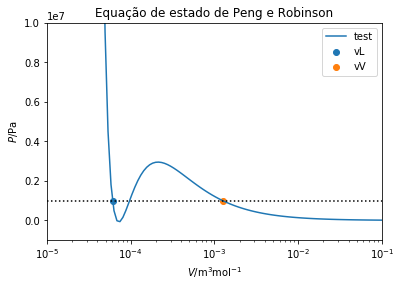

In [9]:
Ptest=1e6
vL, vV, nVphys  = func_VL_VV_cubic(T=Ttest,P=Ptest)
print ("vL, vV, nVphys")     
print(vL, vV, nVphys)    
    
plt.plot(seqVm,seqP,label='test') 
plt.scatter(vL,Ptest,label="vL") 
plt.scatter(vV,Ptest,label="vV") 
plt.axhline(Ptest,color='black',ls=':')

plt.xlabel(r'${V} / \mathrm{m^{3}mol^{-1}}$')
plt.ylabel(r'$P / \mathrm{Pa}$')
plt.title('Equação de estado de Peng e Robinson') 
plt.ylim(-1e6,1e7)
plt.xlim(1e-5,1e-1) 
plt.xscale('log')
plt.legend()
plt.show()  

# Faixa de busca para pressão de saturação
(metodologia baseada em Topliss, Dimitrelis & Prausnitz, 1988)

Sabendo que a pressão de saturação está na faixa de pressão para a qual há três raízes de volume, a região de busca pode ser definida pelo cálculo do mínimo e máximo locais da isoterma:

dado $T$, buscar $V^*$ tal que $\left(\frac{\partial P}{\partial V}\right)_T=0$

Filtram-se apenas os valores físicos: $V^*$ entre $b$ e $\infty$

$$ \left( \frac{\partial P}{\partial V} \right) _T= 0$$

usando a equação de Soave, obtemos a seguinte expressão para essa derivada parcial

$$\frac{\partial{P}}{\partial{V}} = - \frac{R T}{\left(V - b\right)^{2}} - \frac{a \left(- 2 V - b u\right)}{\left(V^{2} + V b u + b^{2} w\right)^{2}}$$

como buscamos os valores de V para os quais a expressão dá zero, podemos multiplicar ambos os lados da equação pelos denominadores de cada termo, obtendo assim

$$- R T \left(V^{2} + V b u + b^{2} w\right)^{2} - a \left(- 2 V - b u\right) \left(V - b\right)^{2} = 0$$

realizando as operações distributivas, potências de somas e coletando os coeficientes de iguais potências de V chegamos a representação polinomial

$$V^{4} - \frac{V^{3}}{R T} \left(- 2 R T b u + 2 a\right) - \frac{V^{2}}{R T} \left(- R T b^{2} u^{2} - 2 R T b^{2} w + a b u - 4 a b\right) - \frac{V}{R T} \left(- 2 R T b^{3} u w - 2 a b^{2} u + 2 a b^{2}\right) - \frac{1}{R T} \left(- R T b^{4} w^{2} + a b^{3} u\right) = 0$$

A qual pode ser convenientemente expressa por coeficientes $c_0$, $c_1$, $c_2$, $c_3$ e $c_4$.

$$ c_4V^4 + c_3 V^3+c_2V^2+c_1 V+c_0=0$$

em que

$c_4 = 1$

$c_3 = (-2RTbu + 2a)/(-RT)$

$c_2 = (-RTb^2u^2 - 2RTb^2w + abu - 4ab)/(-RT)$

$c_1 = (-2RTb^3uw - 2ab^2u + 2ab^2)/(-RT)$

$c_0 = (-RTb^4w^2 + ab^3u)/(-RT)$

In [10]:
def func_Plimits(T):
    #cálculo dos limites para busca de pressão de saturação
    
    #calcular coeficientes da representação polinomial
    a=func_a(T=T)
    
    c4 = 1
    c3 = (-2*R*T*b*u + 2*a)/(-R*T)
    c2 = (-R*T*b**2*u**2 - 2*R*T*b**2*w + a*b*u - 4*a*b)/(-R*T)
    c1 = (-2*R*T*b**3*u*w - 2*a*b**2*u + 2*a*b**2)/(-R*T)
    c0 = (-R*T*b**4*w**2 + a*b**3*u)/(-R*T)
    
    #resolver raízes com a função roots
    list_coeffs=[c4,c3,c2,c1,c0]

    V1,V2,V3,V4=np.roots(list_coeffs) #Como c4=1, nunca vai vir menos de quatro raízes (incluindo real e complexa)
    
    imag_tol = 1e-11

    listVphysical=[]
    
    for V in [V1,V2,V3,V4]:
        if (abs(V.imag) < imag_tol) and (V.real > b): #condicao para existencia de um valor real
            listVphysical.append(V.real)
    nVphysical = len(listVphysical)
    
    if nVphysical >= 1:
        Vinfi = min(listVphysical)
        Vsupi = max(listVphysical)
    
    
        #calcular a pressão correspondente a cada raiz de volume selecionada
        Psup = func_P_soave(T=T,Vm=Vsupi)
        Pinf = func_P_soave(T=T,Vm=Vinfi)

        #definir com limite superior uma pressão ligeiramente abaixo da pressão limite superior
        #e ligeiramente acima da pressão limite inferior para garantir que existam três volumes nas condições teste
        #não levar pressão negativa para o cálculo de pressão de saturação
        Psupi=Psup*.999999
    
        if Pinf > 0:
            Pinfi = Pinf*1.000001
        else:
            Pinfi = Psupi/1e10
            
    elif nVphysical==0:
        #não achamos faixa de busca
        Vli=None
        Vvi=None
        Psupi=None
        Pinfi=None
        
    return Vinfi,Vsupi,Pinfi,Psupi,nVphysical

In [11]:
Vinfi,Vsupi,Pinfi,Psupi,nPlim=func_Plimits(T=120)
print("nPlim:",nPlim)
print("Vli:",Vinfi)
print("Vvi:",Vsupi)
print("Psupi:",Psupi)
print("Pinfi:",Pinfi)

nPlim: 2
Vli: 5.12869412052e-05
Vvi: 0.000451189451291
Psupi: 1059459.53909
Pinfi: 0.000105945953909


* validação gráfica

In [12]:
Vinfilim,Vsupilim,Pinfilim,Psupilim,nPlim=func_Plimits(T=Ttest)
print("nPlim:",nPlim)

nPlim: 2


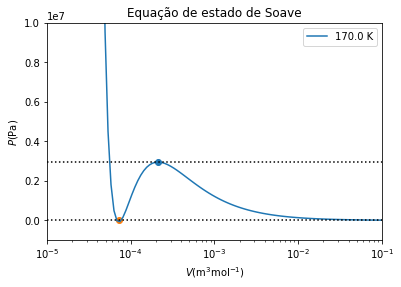

In [13]:
plt.semilogx(seqVm,seqP,label=str(Ttest)+' K') #create a logarithm vs logarithm scale plot of pressure vs volume, using the function pressure in each value of the volume list
plt.ylabel(r'$P (\mathrm{Pa})$') #create labels to be displayed in y axis of the plot
plt.xlabel(r'${V} (\mathrm{m^{3}mol^{-1}})$') #use matplotlib's  mathtext to create special symbols in the x label
plt.title('Equação de estado de Soave') #create a title for the figure
plt.ylim(-1e6,1e7)#define max and min limits of the y axis only to the positive pressure range. remember that this plot is in logarithm scale and it does not accept negative values.
plt.xlim(1e-5,1e-1) #define max and min limits of the x axis
if nPlim>0:
    plt.scatter(Vsupilim,Psupilim)
    plt.axhline(Psupilim,color='black',ls=':')
    plt.scatter(Vinfilim,Pinfilim)
    plt.axhline(Pinfilim,color='black',ls=':')
plt.legend()
plt.show()

## G residual

$$A^{\mathrm{RES}} = - R T \ln{\left (\frac{V}{V^{IG}} \right )} - R T \ln{\left (\frac{1}{Z} \left(- B + Z\right) \right )} + \frac{a}{b \sqrt{u^{2} - 4 w}} \ln{\left (\frac{B \left(u - \sqrt{u^{2} - 4 w}\right) + 2 Z}{B \left(u + \sqrt{u^{2} - 4 w}\right) + 2 Z} \right )}$$

> Reid, Prausnitz & Poling, 1987, pp 102

logo, como $G = A+PV$

temos que $G^{IG} = A^{IG}+PV^{IG}$

logo

$$G^\mathrm{RES} = A^\mathrm{RES}+P(V-V^{IG})$$

$$G^{\mathrm{RES}} = R T (Z-1) - R T \ln{\left ( - B + Z \right )} + \frac{a}{b \sqrt{u^{2} - 4 w}} \ln{\left (\frac{B \left(u - \sqrt{u^{2} - 4 w}\right) + 2 Z}{B \left(u + \sqrt{u^{2} - 4 w}\right) + 2 Z} \right )}$$



In [14]:
def func_Gres_RT(T,P,Z):    
    a=func_a(T)
    A=a*P/(R**2*T**2)
    B=b*P/(R*T)
    T1=A/(B*(u**2-4*w)**.5)
    T2=(-1)
    T3=2*Z+B*(u+(u**2-4*w)**.5)
    T4=2*Z+B*(u-(u**2-4*w)**.5)
    Gres_RT_TPZ = (Z-1)-np.log(Z-B)+T1*T2*np.log(T3/T4)
    return Gres_RT_TPZ

## o critério de equilíbrio

$$\mu_i^L=\mu_i^V$$

no caso do puro, $G=\mu_i$

$$G^\mathrm{L}=G^\mathrm{V}$$

usando uma mesma referência

$$G^\mathrm{L}-G^\mathrm{IG}=G^\mathrm{V}-G^\mathrm{IG}$$

$$ G^\mathrm{RES,L}=G^\mathrm{RES,V} $$

ou com as variáveis adimensionadas dividinto pelo produto $(RT)$

$$ \frac{G^\mathrm{RES,L}}{RT}=\frac{G^\mathrm{RES,V}}{RT} $$

* verificar existẽncia de solução em uma temperatura teste

In [15]:
Vinfi,Vsupi,Pinfi,Psupi,nVlim=func_Plimits(Ttest)

nP=100
Gres_RT_L=np.zeros(nP)
Gres_RT_V=np.zeros(nP)

seqP2 = np.linspace(Pinfi,Psupi,nP)
Vmi_L=np.zeros(nP)
Vmi_V=np.zeros(nP)
Z_L=np.zeros(nP)
Z_V=np.zeros(nP)
nV=np.zeros(nP)
for i in range(nP):
    Vmi_L[i],Vmi_V[i],nV[i] = func_VL_VV_cubic(T=Ttest,P=seqP2[i])
    Z_L[i]=(seqP2[i]*Vmi_L[i])/(R*Ttest)
    Z_V[i]=(seqP2[i]*Vmi_V[i])/(R*Ttest)
    Gres_RT_L[i] = func_Gres_RT(T=Ttest,P=seqP2[i],Z=Z_L[i])
    Gres_RT_V[i] = func_Gres_RT(T=Ttest,P=seqP2[i],Z=Z_V[i])

* plot

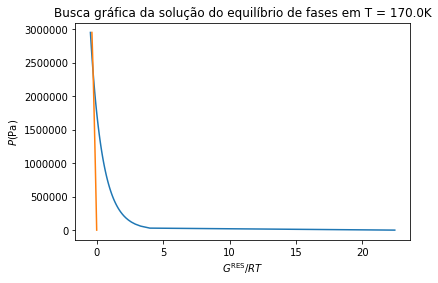

In [16]:
plt.plot(Gres_RT_L,seqP2)
plt.plot(Gres_RT_V,seqP2)

plt.xlabel(r'$G^\mathrm{RES}/RT$') #create labels to be displayed in y axis of the plot
plt.ylabel(r'$P (\mathrm{Pa})$') #use matplotlib's  mathtext to create special symbols in the x label
plt.title('Busca gráfica da solução do equilíbrio de fases em T = '+str(Ttest)+'K') #create a title for the figure

plt.show()

## Pressão de saturação

In [17]:
def func_Psat(T):
    
    def func_RES(P):
        VL,VV,nV=func_VL_VV_cubic(T=T,P=P)
        ZL=VL*P/(R*T)
        ZV=VV*P/(R*T)
        Gres_RT_L=func_Gres_RT(T=T,P=P,Z=ZL)
        Gres_RT_V=func_Gres_RT(T=T,P=P,Z=ZV)
        return Gres_RT_L-Gres_RT_V

    Vinfi,Vsupi,Psupi,Pinfi,nlim=func_Plimits(T=T)
    P0a=Pinfi
    P0b=Psupi
    
    Psati = opt.bisect(func_RES,P0a,P0b)
    
    return Psati

Psat_test = func_Psat(T=Ttest)
Psat_test

2358783.478269603

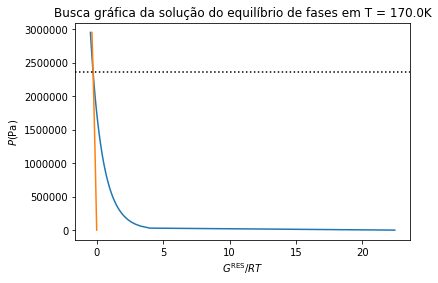

In [18]:
plt.plot(Gres_RT_L,seqP2)
plt.plot(Gres_RT_V,seqP2)
plt.axhline(Psat_test,color='k',ls=":")

plt.xlabel(r'$G^\mathrm{RES}/RT$') #create labels to be displayed in y axis of the plot
plt.ylabel(r'$P (\mathrm{Pa})$') #use matplotlib's  mathtext to create special symbols in the x label
plt.title('Busca gráfica da solução do equilíbrio de fases em T = '+str(Ttest)+'K') #create a title for the figure

plt.show()

* cálculo em sequência

In [19]:
nPsat=100
seqT3=np.linspace(Tc/3,Tc*.99,nPsat)
seqP3=np.zeros(nPsat)
for i in range(nPsat):
    seqP3[i]=func_Psat(seqT3[i])

* plot

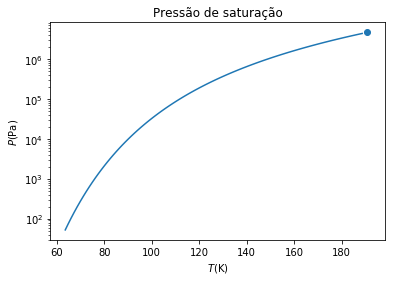

In [20]:
plt.plot(seqT3,seqP3)
plt.scatter(Tc,Pc)
plt.yscale('log')

plt.xlabel(r'$T(\mathrm{K})$') #create labels to be displayed in y axis of the plot
plt.ylabel(r'$P (\mathrm{Pa})$') #use matplotlib's  mathtext to create special symbols in the x label
plt.title('Pressão de saturação') #create a title for the figure

plt.show()

## envelope

In [21]:
VL_seq=np.zeros(nPsat)
VV_seq=np.zeros(nPsat)
nV_seq=np.zeros(nPsat)
for i in range(nPsat):
    VL_seq[i],VV_seq[i],nV_seq[i]=func_VL_VV_cubic(T=seqT3[i],P=seqP3[i])

#amarração de VL VV em equilíbrio das isotermas
Psat_test=func_Psat(Ttest)
VL_test,VV_test,nV_test=func_VL_VV_cubic(T=Ttest,P=Psat_test)

In [22]:
vl,vv,n = func_VL_VV_cubic(T=Tc,P=Pc)
print(vl,vv,n)
vc=vv

0.000112750267236 0.000112750267236 1


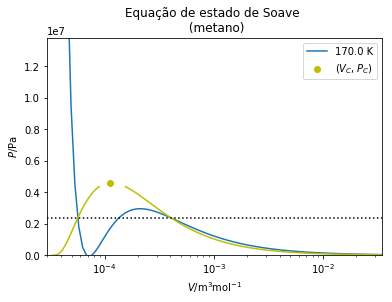

In [24]:
plt.plot(seqVm,seqP,label=str(Ttest)+' K') #create a logarithm vs logarithm scale plot of pressure vs volume, using the function pressure in each value of the volume list
plt.ylabel(r'$P / \mathrm{Pa}$') #create labels to be displayed in y axis of the plot
plt.xlabel(r'${V} / \mathrm{m^{3}mol^{-1}}$') #use matplotlib's  mathtext to create special symbols in the x label
plt.title('Equação de estado de Soave \n (metano)') #create a title for the figure
plt.ylim(0,Pc*3)#define max and min limits of the y axis only to the positive pressure range. remember that this plot is in logarithm scale and it does not accept negative values.
plt.xlim(b,(R*Tc/Pc)*100) #define max and min limits of the x axis
plt.xscale('log')

plt.plot(VL_seq,seqP3, color='y')
plt.plot(VV_seq,seqP3, color='y')


plt.axhline(Psat_test,color='black',ls=':')

plt.scatter(vc,Pc,color='y',label=r'$(V_{C},P_{C})$')
      
plt.legend()

plt.show()

# diagrama de fases no envelope P versus H

In [ ]:
# def Cpgi(T): #integral cpdT
#     To = 273.15
#     Cpgi=R*(A1*(T-To)+(B1/2)*(T**2-To**2)+(C1/3)*(T**3-To**3))
#     return Cpgi

# #parâmetros retirados do anexo para o n-Pentano
# A1 = 2.464
# B1 = 45.351*10**(-3)
# C1 = -14.111*10**(-6)

# #calculo de Hideal considerando como temperatura de referência 273.15K
# def Hideal(T):
#     return Cpgi(T)

# #calculo de Hreal considerando como temperatura de referência 273.15K
# def Hreal(P,T,Z):
#     return Hres(P,T,Z)+Cpgi(T)

# def da(T): #definição de da/dT
#     Tr = T/Tc
#     da = (-0.45724*(R*Tc)**2/Pc)*fw*((1+fw*(1-Tr**.5))**2/(Tc*T))**.5  
#     return da

# def Hres(P,T,Z): #definição de Hres
#     B=(b*P)/(R*T)
#     Hres = R*T*(Z-1+((T*da(T)-a(T))/(R*T*2*b*(2)**0.5))*np.log((Z+(1+2**0.5)*B)/(Z+(1-2**0.5)*B)))
#     return Hres

In [ ]:
# #CALCULAR H PARA CADA TSAT/PSAT/VSATL E TSAT/PSAT/VSATV

# VL_seq=np.zeros(nPsat)
# VV_seq=np.zeros(nPsat)
# nV_seq=np.zeros(nPsat)
# for i in range(nPsat):
#     VL_seq[i],VV_seq[i],nV_seq[i]=func_VL_VV_cubic(T=seqT3[i],P=seqP3[i])

# #amarração de VL VV em equilíbrio das isotermas
# Psat_test=func_Psat(Ttest)
# VL_test,VV_test,nV_test=func_VL_VV_cubic(T=Ttest,P=Psat_test)

In [ ]:
# #CALCULAR H PARA seqV DADO T

# VL_seq=np.zeros(nPsat)
# VV_seq=np.zeros(nPsat)
# nV_seq=np.zeros(nPsat)
# for i in range(nPsat):
#     VL_seq[i],VV_seq[i],nV_seq[i]=func_VL_VV_cubic(T=seqT3[i],P=seqP3[i])

# #amarração de VL VV em equilíbrio das isotermas
# Psat_test=func_Psat(Ttest)
# VL_test,VV_test,nV_test=func_VL_VV_cubic(T=Ttest,P=Psat_test)

# nV=1000
# val_V= np.logspace(np.log10(b*1.01),2+np.log10(R*Tc/Pc),nV)
# listH=[]
# listP=[]
# for T in val_T:
#     val_P=np.zeros(nV)
#     val_H=np.zeros(nV)
#     Z=np.zeros(nV)
#     for i in range(nV):
#         val_P[i]= P_Peng (T,val_V[i])
#         Z[i]=(val_P[i]*val_V[i])/(R*T)
#         val_H[i]=Hreal(val_P[i],T,Z[i])
#     listH.append(val_H)
#     listP.append(val_P)
# listH

In [ ]:
# nT = len(val_T)
# for i in range(nT): #isotermas
#     plt.plot(listH[i],listP[i],label=str(val_T[i])+' K')
#     plt.yscale('log')
#     plt.ylabel(r'$P (\mathrm{Pa})$')
#     plt.xlabel(r'${H} (\mathrm{J/Kg)}})$')

# for i in range(nT): #envelope
#     plt.plot(Hreal_L1,Pseq, color='y')
#     plt.plot(Hreal_V1,Pseq, color='y')
#     plt.yscale('log')
#     plt.ylabel(r'$P (\mathrm{Pa})$')
#     plt.xlabel(r'${H} (\mathrm{J/kg})$')
#     plt.title('n-Pentano')
#     plt.xlim(-20000,30000)
#     plt.ylim(1e5,1e8)
    
#     plt.scatter(Hrealc,Pc, color='y')
    
# plt.legend()
# plt.show()

In [ ]:
# def Sres(P,T,Z): #cálculo da S residual
#     B=b*P/(R*T)
#     Sres = R*(np.log(Z-B)+(da(T)/(R*2*b*(2)**0.5))*np.log((Z+(1+2**0.5)*B)/(Z+(1-2**0.5)*B)))
#     return Sres

In [ ]:
# def CpgiS(T): #cálculo da integral Cp/TdT
#   To=273.15
#   CpgiS=R*(A1*np.log(T/To)+B1*(T-To)+(C1/2)*(T**2-To**2))
#   return CpgiS

In [ ]:
# #Cálculo de S ideal
# def Sideal(P,T,Z):
#   Pref=1*10**5 #Pa
#   Sideal = CpgiS(T)-R*np.log(P/Pref)
#   return Sideal

In [ ]:
# #Cálculo de Sreal
# def Sreal(P,T,Z):
#   Pref=1*10**5 #Pa
#   Sreal = Sres(P,T,Z)+CpgiS(T)-R*np.log(P/Pref)
#   return Sreal

In [ ]:
# #Cálculo de T através de Van der Waals
# from scipy.optimize import fsolve

  
# def T_PengRobinson(P,V):
#     from scipy.optimize import fsolve
#     a=27*R**2*Tc**2/(64*Pc)
#     b=R*Tc/(8*Pc)
#     def T_VanderWaals(P,V):
#         return (P + a/V**2 )*(V-b)/R

#     def RES(T):
#         return P-P_PengRobinson(T,V)

#     T=fsolve(func=RES,x0=T_VanderWaals(P,max(V,1.01*b)))

#     return T

# Ptest=P_PengRobinson(200,1e-5)
# print(Ptest)
# print( T_PengRobinson(Ptest,1e-5) )


In [ ]:
# # envelope

# nTP=1000
# Tseq=np.linspace(300,Tc*.99,nTP)
# Pseq=np.zeros(nTP)
# VL_seq=np.zeros(nTP)
# VV_seq=np.zeros(nTP)
# ZL_seq=np.zeros(nTP)
# ZV_seq=np.zeros(nTP)
# nV_seq=np.zeros(nTP)
# Sreal_L1=np.zeros(nTP)
# Sreal_V1=np.zeros(nTP)

# for i in range(nTP):
#     Pseq[i]=P_sat(Tseq[i])
#     VL_seq[i],VV_seq[i],ZL_seq[i],ZV_seq[i],nV_seq[i]=V_cubic(Tseq[i],Pseq[i])
#     Sreal_L1[i]= Sreal(Pseq[i],Tseq[i],ZL_seq[i])
#     Sreal_V1[i] = Sreal(Pseq[i],Tseq[i],ZV_seq[i])

In [ ]:
# # isobaras

# val_P=Pc*np.array([.5,.7,.95,1,1.25]) #valores de pressão estipulados
# nV=1000
# val_V= np.logspace(np.log10(1.01*b),2+np.log10(R*Tc/Pc),nV) #valores de pressão estipulados
# listT=[]
# listS=[]
# for P in val_P: #para cada uma das pressões, será calculado um vetor com valores de T e um com valores de S
#     val_T=np.zeros(nV)
#     val_S=np.zeros(nV)
#     Z=np.zeros(nV)
#     for i in range(nV): #para cada volume terá um valor de T e um de S
#         val_T[i]= TPeng (P,val_V[i])
#         Z[i]=(P*val_V[i])/(R*val_T[i])
#         val_S[i]=Sreal(P,val_T[i],Z[i])
#     listT.append(val_T)
#     listS.append(val_S)

In [ ]:
# for i in range(nT):
#     plt.plot(Sreal_L1,Tseq, color='y')
#     plt.plot(Sreal_V1,Tseq, color='y')
#     plt.ylabel(r'$T (\mathrm{K})$') 
#     plt.xlabel(r'${S} (\mathrm{J/kg})$')
#     plt.title('n-Pentano')
#     plt.xlim(-70,50)
#     plt.ylim(300,550)
#     plt.scatter(Srealc,Tc, color='y')

#     for i in range(len(listS)): #desenho das isobáricas
#         plt.plot(listS[i],listT[i])    
# plt.show()


# Conclusão

A solução do equilibrio liquido vapor por eos não é simples. há que se preocupar com solução trivial (GresL=GresV | vl=vv; eos retornando uma unica raiz real; dificuldade de convergencia dos metodo numericos...)



# Referências

>* Reid, R. C., Prausnitz, J. M. and Poling, B. E., 1987. The Properties of Gases and Liquids. 4th ed., McGraw-Hill. [ISBN: 0070517991, 9780070517998
](https://books.google.com.br/books?id=AcRTAAAAMAAJ)

>* Smith, J. M., van Ness, H. C. and Abbott, M. M., 2007. Introdução a termodinâmica da engenharia química. 7a ed., LTC. [ISBN: 8521615531, 9788521615538](https://books.google.com.br/books?id=TzeQPgAACAAJ)


>* Topliss, R J., Dimitrelis D., and Prausnitz, J. M., 1988, “Computational Aspects of a Non-Cubic Equation of State for Phase-Equilibrium Calculations. Effect of Density-Dependent Mixing Rules.” Computers & Chemical Engineering 12 (5): 483–89. [doi:10.1016/0098-1354(88)85067-1](http://dx.doi.org/10.1016/0098-1354(88)85067-1)

>* [numpy.roots ](https://docs.scipy.org/doc/numpy/reference/generated/numpy.roots.html)
>* [scipy.optimize.bisect](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.bisect.html)